In [1]:
import string
from string import punctuation
from os import listdir
from collections import Counter
import re
import unicodedata

import pandas as pd
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk    
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet

[nltk_data] Downloading package stopwords to /work/home/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /work/home/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import pickle

# Étape 1 : Télécharger et importer les données

Les données qui nous intéressent sont des commentaires de films. 

Nous avons utilisé les données <a href="http://ai.stanford.edu/~amaas/data/sentiment/">IMDb Reviews</a>. On peut les télécharger facilement en cliquant sur ce lien, puis sur "Large Movie Review Dataset v1.0". Le fichier aclImdb_v1.tar.gz sera alors téléchargé. Il suffira de l'extraire puis d'utiliser les fichiers .txt dans les dossiers neg et pos.

Nous importons maintenant les commentaires positifs et négatifs, en les mettant dans des listes negative_dataset et positive_dataset.

In [46]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

negative_dataset = []
for filename in listdir('txt_sentoken/neg'):
    if not filename.endswith(".txt"):
        continue
    path = 'txt_sentoken/neg' + '/' + filename
    read_file = load_doc(path)
    negative_dataset.append(read_file)  
    
positive_dataset = []
for filename in listdir('txt_sentoken/pos'):
    if not filename.endswith(".txt"):
        continue
    path = 'txt_sentoken/pos' + '/' + filename
    read_file = load_doc(path)
    positive_dataset.append(read_file)

In [47]:
n_neg = len(negative_dataset)
n_pos = len(positive_dataset)
print(n_pos + n_neg)

22704


Nous avons alors un jeu de données de 22704 commentaires.

# Étape 2 : Pré-traitement des données

Les commentaires bruts contiennent beaucoup de caractères, de ponctuation notamment qui ne nous permettront pas de faire une étude correcte sur ces commentaires.
Il faut alors "nettoyer" nos données.

Voici un exemple de commentaire "brut".

In [48]:
positive_dataset[0]

"If you like adult comedy cartoons, like South Park, then this is nearly a similar format about the small adventures of three teenage girls at Bromwell High. Keisha, Natella and Latrina have given exploding sweets and behaved like bitches, I think Keisha is a good leader. There are also small stories going on with the teachers of the school. There's the idiotic principal, Mr. Bip, the nervous Maths teacher and many others. The cast is also fantastic, Lenny Henry's Gina Yashere, EastEnders Chrissie Watts, Tracy-Ann Oberman, Smack The Pony's Doon Mackichan, Dead Ringers' Mark Perry and Blunder's Nina Conti. I didn't know this came from Canada, but it is very good. Very good!"

In [49]:
print(negative_dataset[1],'\n',)

I saw the capsule comment said "great acting." In my opinion, these are two great actors giving horrible performances, and with zero chemistry with one another, for a great director in his all-time worst effort. Robert De Niro has to be the most ingenious and insightful illiterate of all time. Jane Fonda's performance uncomfortably drifts all over the map as she clearly has no handle on this character, mostly because the character is so poorly written. Molasses-like would be too swift an adjective for this film's excruciating pacing. Although the film's intent is to be an uplifting story of curing illiteracy, watching it is a true "bummer." I give it 1 out of 10, truly one of the worst 20 movies for its budget level that I have ever seen. 



Pour ce faire, on peut choisir de :

 - Segmenter les commentaire en "tokens", ici un token représentera un mot
 - Supprimer la ponctuation
 - Supprimer tous les nombres et caractères spéciaux
 - Mettre tout en minuscule
 - Supprimer les mots à une lettre
 - Supprimer les mots tels que "the", this"... appelés "stopwords"
 - Lemmatiser, c'est-à-dire, prendre la racine des mots. Par exemple, les mots "stepping", "stepped", "steps" seront transformés en "step"

On utilise la librairie nltk pour la lemmatisation.

In [50]:
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer() 

On écrit alors la fonction qui va nous permettre de "nettoyer" les commentaires.

In [51]:
from nltk.util import ngrams
def clean_doc(doc):
    # tokenisation
    tokens = nltk.word_tokenize(doc)
    # suppression de la ponctuation
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    tokens = [w.translate(table) for w in tokens]
    # remplacement des espaces multiples en un seul espace
    tokens = [re.sub(r'\s+', ' ', word, flags=re.I) for word in tokens]
    # suppression des caractères spéciaux
    tokens = [word for word in tokens if word.isalpha()]
    # minuscule
    tokens = [word.lower() for word in tokens]
    # suppression des tokens de longueur inférieure à 1
    tokens = [word for word in tokens if len(word) > 1]
    # suppression des stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # lemmatisation
    tokens = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokens]
    # étant donné que les commentaires concernent des films on supprime les mots "basiques"
    basic_words = ['film', 'movie', 'one', 'character', 'scene', 'make', 'see', 'go','story','time','br']
    tokens = [w for w in tokens if not w in basic_words]
    return tokens

On crée également un dictionnaire "vocab" contenant tous les mots de ce corpus.

In [53]:
vocab = Counter()
tidy_review_neg = []

for review in negative_dataset:
    token = clean_doc(review)
    vocab.update(token)
    review = ' '.join(word for word in token)
    tidy_review_neg.append(review)
    
tidy_review_pos = []

for review in positive_dataset:
    token = clean_doc(review)
    vocab.update(token)
    review = ' '.join(word for word in token)
    tidy_review_pos.append(review)

In [54]:
print("Le vocabulaire contient : %s mots" 
       % len(vocab))

Le vocabulaire contient : 59473 mots


On obtient alors ce commentaire "nettoyé".

In [55]:
tidy_review_neg[0]

'robert deniro play unbelievably intelligent illiterate wasteful talent truly disgust script unbelievable dialog unbelievable jane fonda caricature funny move snail pace photograph manner insufferably preachy also plug every cliche book swoozie kurtz excellent support role equally annoy new imdb rule require ten line every review worthless require ten line text let reader know waste tape avoid'

In [56]:
data_neg = {'Reviews':negative_dataset,'Tidy_Reviews':tidy_review_neg, 'label': [1]*n_neg}
data_neg = pd.DataFrame(data_neg)
data_pos = {'Reviews':positive_dataset, 'Tidy_Reviews':tidy_review_pos, 'label': [0]*n_pos}
data_pos = pd.DataFrame(data_pos)

In [57]:
dataset = pd.concat([data_neg, data_pos])

On a le dataset suivant où les commentaires négatifs sont labélisés 1, et les commentaires positifs sont labélisés 0.

In [58]:
dataset.head(10)

,Reviews,Tidy_Reviews,label
0,Robert DeNiro plays the most unbelievably inte...,robert deniro play unbelievably intelligent il...,1
1,"I saw the capsule comment said ""great acting.""...",saw capsule comment say great act opinion two ...,1
2,If I had not read Pat Barker's 'Union Street' ...,read pat barker street would like unfortuntate...,1
3,This fanciful horror flick has Vincent Price p...,fanciful horror flick vincent price play mad m...,1
4,I basically skimmed through the movie but just...,basically skim enough catch watch plot tell tr...,1
5,"From the beginning of the movie, it gives the ...",begin give feel director try portray something...,1
6,This is really a new low in entertainment. Eve...,really new low entertainment even though lot b...,1
7,"6/10 Acting, not great but some good acting.<b...",act great good director stupid decision writer...,1
8,"This is one of the dumbest films, I've ever se...",dumbest ever rip nearly ever type thriller man...,1
9,"This film had a lot of promise, and the plot w...",lot promise plot relatively interest however a...,1


In [59]:
dataset.to_pickle("clean_data.pkl") 

dataset = dataset.drop(columns=['Tidy_Reviews'])
# mélange les reviews
dataset = dataset.sample(frac=1)
dataset = dataset.rename(columns={"label": 'label', "Reviews": 'text'})


In [60]:
from sklearn.model_selection import train_test_split
train, data_test, label_train, label_test = train_test_split(dataset["text"], dataset["label"], test_size=0.2, random_state=42)
valid, test, label_valid, label_test = train_test_split(data_test, label_test, test_size=0.5, random_state=42)

train = pd.DataFrame({'text': train, 'label': label_train})
test = pd.DataFrame({'text': test, 'label': label_test})
valid = pd.DataFrame({'text': valid, 'label': label_valid})

train.to_csv (r'data/train.csv', index = False, header=True)
test.to_csv (r'data/test.csv', index = False, header=True)
valid.to_csv (r'data/valid.csv', index = False, header=True)

On peut ensuite choisir de représenter les mots les plus fréquents dans les commentaires positifs et négatifs.

Pour cela, on utilise la librairie wordcloud. Les mots les plus fréquents sont de grandes tailles.

In [217]:
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests

 - Les mots dans les commentaires positifs

In [218]:
all_words_positive = ' '.join(text for text in dataset['Tidy_Reviews'][dataset['label']==0])
Mask = np.array(Image.open('movie1.jpg'))
image_colors = ImageColorGenerator(Mask)
wc = WordCloud(background_color='white', height=1500, width=4000,mask=Mask).generate(all_words_positive)

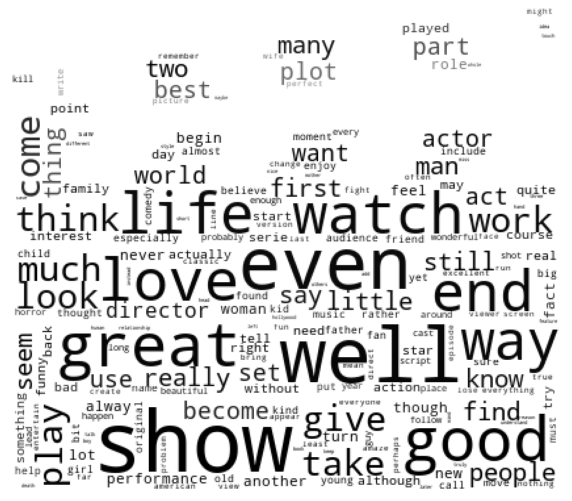

In [219]:
plt.figure(figsize=(10,20))
plt.imshow(wc.recolor(color_func=image_colors),interpolation="hamming")
plt.axis('off')
plt.show()

 - Les mots dans les commentaires négatifs

In [220]:
all_words_negative = ' '.join(text for text in dataset['Tidy_Reviews'][dataset['label']==1])
Mask = np.array(Image.open('movie1.jpg'))
image_colors = ImageColorGenerator(Mask)
wc = WordCloud(background_color='white', height=1500, width=4000,mask=Mask).generate(all_words_negative)

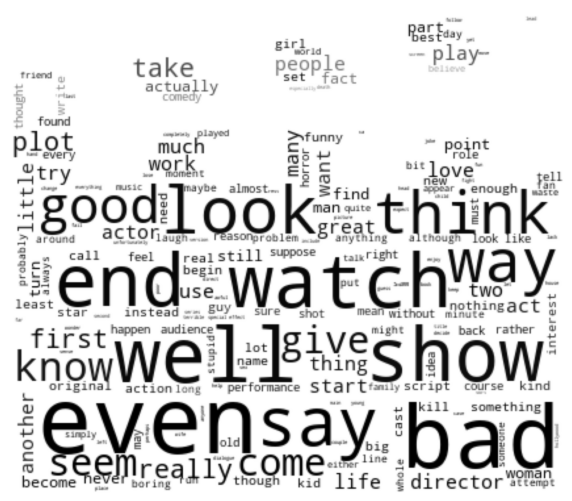

In [221]:
plt.figure(figsize=(10,20))
plt.imshow(wc.recolor(color_func=image_colors),interpolation="gaussian")
plt.axis('off')
plt.show()

On remarque que les mots qui ressortent des commentaires positifs sont plutôt positifs et que ceux des commentaires négatifs sont négatifs ou neutres. 
Par exemple, "show", "watch" sont des mots sans connotations particulières qui sont fréquents à la fois dans les commentaires positifs et négatifs.

 - Dans tous le dataset

In [222]:
freq_words = pd.DataFrame({'Word':list(vocab.keys()),'Count':list(vocab.values())})
freq_words.to_pickle("vocab.pkl") 

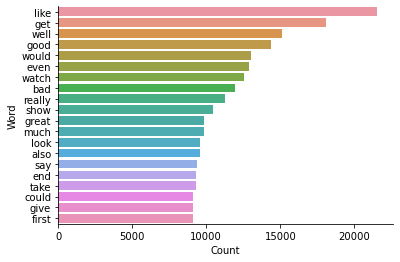

In [223]:
freq_words_plot = freq_words.nlargest(20,columns='Count')
sns.barplot(data=freq_words_plot,y='Word',x='Count')
sns.despine()

Le mot le plus fréquent est "like".

# Étape 3 : Vectorisation

Pour que nos données puissent être comprises par les algorithmes de Machine Learning, on doit convertir les commentaires en représentation numérique.

On sépare d'abord nos données en données d'entraînement et en données de test.

In [224]:
from sklearn.model_selection import train_test_split

In [225]:
# mélanger les données
dataset = dataset.sample(frac=1)

In [226]:
reviews_train, reviews_test, label_train, label_test = train_test_split(dataset["Tidy_Reviews"], dataset["label"], test_size=0.33, random_state=42)

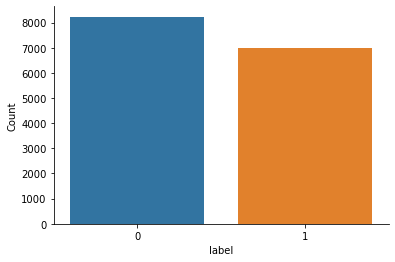

In [227]:
l = Counter(label_train)
labels = pd.DataFrame({'label':list(l.keys()),'Count':list(l.values())})
sns.barplot(data=labels,x='label',y='Count')
sns.despine()

On observe que dans notre jeu de données d'entraînement il y a un peu plus de commentaire positifs que de commentaires négatifs. Mais le jeu reste tout de même assez équilibré.

## Bag-of-word

Nous utilisons dans un premier temps, la représentation appelée "Bag-of-word.
Elle consiste à créer une grande matrice avec une colonne pour chaque mot unique dans le corpus.
Chaque commentaire correspond à une ligne contenant des 0 et des 1, où 1 signifie que le mot dans le corpus correspondant à cette colonne apparaît dans ce commentaire.
Chaque ligne de la matrice sera alors creuse, car il y aura beaucoup de zéros.
Ce processus est également appelé "one hot encoding".

In [228]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(binary=True)
cv.fit(reviews_train)
X = cv.transform(reviews_train)
X_test = cv.transform(reviews_test)

## TF-IDF

On peut également utiliser la représentation TF-IDF, elle permet d'évaluer l'importance d'un terme contenu dans un document.

### Term Frequency (TF)

TF représente le nombre de fois qu'un mot apparaît dans un commentaire divisé par le nombre total de mots dans le commentaire.
Chaque commentaire a son propre TF.

$$\mathrm{tf_{i,j}} = \frac{n_{i,j}}{\sum_k n_{i,j}}$$

### Inverse Data Frequency (IDF)

IDF représente le log du nombre de documents divisé par le nombre de documents qui contiennent le mot $t_i$.
IDF determine le poids des mots rares pour tous les commentaires du corpus.

$$\mathrm{idf_i} =  \log \frac{|D|}{|\{d_{j}: t_{i} \in d_{j}\}|}$$

où 
 - $|D|~$ : nombre total de commentaires dans le corpus 
 - $|\{d_{j} : t_{i} \in d_{j}\}|$ : nombre de commentaires où le terme $t_i$ apparaît (c'est-à-dire $n_{i,j} \neq 0$)

Et enfin, TF-IDF est simplement le TF multiplié par le IDF.

$$\mathrm{tfidf_{i,j}} = \mathrm{tf_{i,j}} \cdot  \mathrm{idf_{i}}$$

In [229]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(reviews_train)
X_tfidf = tfidf_vectorizer.transform(reviews_train)
X_test_tfidf = tfidf_vectorizer.transform(reviews_test)

# Étape 4 : Application d'algorithmes de ML

Nous allons maintenant appliquer différents algorithmes de Machine Learning, pour pouvoir déterminer quels algorithmes prédisent le mieux le caractère positif ou négatif des commentaires. 

Nous utilisons ici comme métrique l'accuracy qui peut s'écrire :

$$accuracy = \frac{TP+TN}{TP+TN+FP+FN}\,,$$
où : 
 - TP : vrais positifs
 - TN : vrais négatifs
 - FP : faux positifs
 - FN : faux négatifs
 

## Régression logistique

La régression logistique est un algorithme de Machine Learning qui est utilisé pour prédire la probabilité d'une variable binaire (ici il s'agit de 0 : commentaire positif et 1 : commentaire négatif).

On fait une régression logistique qui utilise une régression Ridge (penalty='l2') de paramètre C.

### Avec Bag-of-word

In [230]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_train, X_val, y_train, y_val = train_test_split(X, label_train, train_size = 0.75)

for c in [0.01, 0.05, 0.25, 0.5, 1]:    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" % (c, accuracy_score(y_val, lr.predict(X_val))))

Accuracy for C=0.01: 0.858269787010255
Accuracy for C=0.05: 0.8711543518275046
Accuracy for C=0.25: 0.8693136997107547
Accuracy for C=0.5: 0.8645805942676834
Accuracy for C=1: 0.860110439127005


Pour C = 0.25, on a l'accuracy la plus élevée.

On applique ce modèle.

In [231]:
final_model = LogisticRegression(C=0.25)
final_model.fit(X, label_train)
print ("Final Accuracy: %s" 
       % accuracy_score(label_test, final_model.predict(X_test)))

Final Accuracy: 0.8737488322434273


On trouve une accuracy d'environ 0.87.

On peut également regarder les 5 mots les plus discriminant pour les commentaires négatifs et positifs.
On regarde alors respectivement les plus grands et les plus petits coefficients.

In [232]:
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), final_model.coef_[0])
}
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_negative)

('waste', 1.4309584567673301)
('awful', 1.3651032550829336)
('poorly', 1.2822741665823933)
('disappointment', 1.173925715098389)
('bad', 1.1433498489632559)


In [233]:
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_positive)

('excellent', -1.1352724849233766)
('refresh', -1.0374117185923102)
('rare', -1.028777119356348)
('perfect', -0.8773145879796556)
('wonderful', -0.8684054576870048)


### Avec TF-IDF

In [234]:
X_train, X_val, y_train, y_val = train_test_split(X_tfidf, label_train, train_size = 0.75)

for c in [0.01, 0.05, 0.25, 0.5, 1]:    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" % (c, accuracy_score(y_val, lr.predict(X_val))))
    

Accuracy for C=0.01: 0.6000525900604786
Accuracy for C=0.05: 0.7854325532474362
Accuracy for C=0.25: 0.8580068367078623
Accuracy for C=0.5: 0.8693136997107547
Accuracy for C=1: 0.8748356560610044


In [235]:
final_model = LogisticRegression(C=1)
final_model.fit(X, label_train)
print ("Final Accuracy: %s" 
       % accuracy_score(label_test, final_model.predict(X_test_tfidf)))

Final Accuracy: 0.8174296009608968


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


On trouve une accuracy de 0.88.

In [236]:
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), final_model.coef_[0])
}
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_negative)

('poorly', 1.7996887656859428)
('waste', 1.7911553504251272)
('disappointment', 1.760984677635607)
('awful', 1.7475698321449427)
('fails', 1.608006356737161)


In [237]:
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_positive)

('refresh', -1.627402630711172)
('rare', -1.5319483578146638)
('excellent', -1.5020958974321315)
('perfect', -1.1776316283092327)
('pleasantly', -1.1693231214944244)


## SVM

On utilise également la régularisation Ridge(l2) de paramètre C.

### Avec bag-of-word

In [238]:
from sklearn.svm import LinearSVC

X_train, X_val, y_train, y_val = train_test_split(
    X, label_train, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    svm = LinearSVC(C=c)
    svm.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, svm.predict(X_val))))

Accuracy for C=0.01: 0.8656323954772548
Accuracy for C=0.05: 0.8624769918485407
Accuracy for C=0.25: 0.8509071785432554
Accuracy for C=0.5: 0.8419668682618985
Accuracy for C=1: 0.8367078622140416


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [239]:
final_svm_ngram = LinearSVC(C=0.5)
final_svm_ngram.fit(X, label_train)
print ("Final Accuracy: %s" 
       % accuracy_score(label_test, final_svm_ngram.predict(X_test)))

Final Accuracy: 0.8538636060322968


### Avec TF-IDF

In [240]:
from sklearn.svm import LinearSVC

X_train, X_val, y_train, y_val = train_test_split(
    X_tfidf, label_train, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    svm = LinearSVC(C=c)
    svm.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, svm.predict(X_val))))

Accuracy for C=0.01: 0.8217196949776492
Accuracy for C=0.05: 0.8627399421509335
Accuracy for C=0.25: 0.8769392584801472
Accuracy for C=0.5: 0.8769392584801472
Accuracy for C=1: 0.8745727057586116


In [241]:
final_svm = LinearSVC(C=0.25)
final_svm.fit(X_tfidf, label_train)
print ("Final Accuracy: %s" 
       % accuracy_score(label_test, final_svm.predict(X_test_tfidf)))

Final Accuracy: 0.8870946216468704


On trouve à peu près la même valeur pour l'accuracy avec les counts et avec tfidf.

## Random Forest

### Avec Bag-of-word

In [242]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X, label_train)

RandomForestClassifier(random_state=0)

In [244]:
print ("Final Accuracy: %s" % accuracy_score(label_test, rf.predict(X_test)))

Final Accuracy: 0.8335780061390631


### Avec TF-IDF

In [245]:
rf_tfidf = RandomForestClassifier(n_estimators=100, random_state=0)
rf_tfidf.fit(X_tfidf, label_train)
print ("Final Accuracy: %s" % accuracy_score(label_test, rf_tfidf.predict(X_test_tfidf)))

Final Accuracy: 0.8399839850527159


# Étape 5 : Comparaison des modèles

Pour comparer les différents modèles, on fait une validation croisée en 10 folds.

LR: 0.868451 (0.005930)
SVM: 0.840905 (0.008498)
RF: 0.835119 (0.010012)


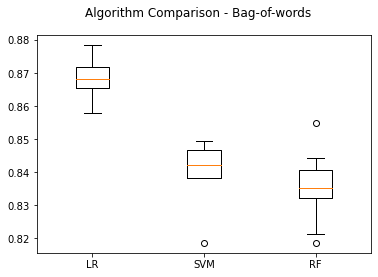

In [246]:
from sklearn import model_selection
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression(C=0.25)))
models.append(('SVM', LinearSVC(C=0.5)))
models.append(('RF', RandomForestClassifier(n_estimators=100, random_state=0)))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X, label_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison - Bag-of-words')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

On trouve que SVM nous donne la meilleure accuray.

LR: 0.853396 (0.009434)
SVM: 0.878838 (0.008599)
RF: 0.831175 (0.010423)


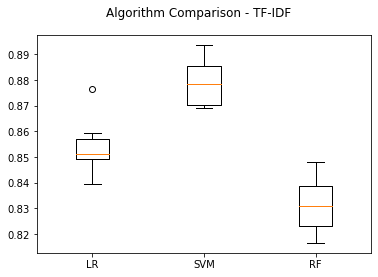

In [247]:
names = []
results = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X_tfidf, label_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison - TF-IDF')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Conclusion

On remarque que les accuracy obtenues sont plutôt élevées et dans le cas de la représentation Bag-of-words, le meilleur algorithme est celui de la régression logistique alors que dans le cas du TF-IDF, le meilleur algorithme est le SVM.